#1. Overview of the drill



Now we will talk about query engines that can sit on top of all the data storage and database technologies we are using with out hadoop cluster.

This query engines actually allows us to execute whatever SQL queries we want across the data no matter where it is stored.

### Where we stand in the world of hadoop?
We have already seen the Core hadoop ecosystem and the External data storage ecosystem (Cassandra, MySQL, MongoDB). Now se will go to the query engines ecosystem.

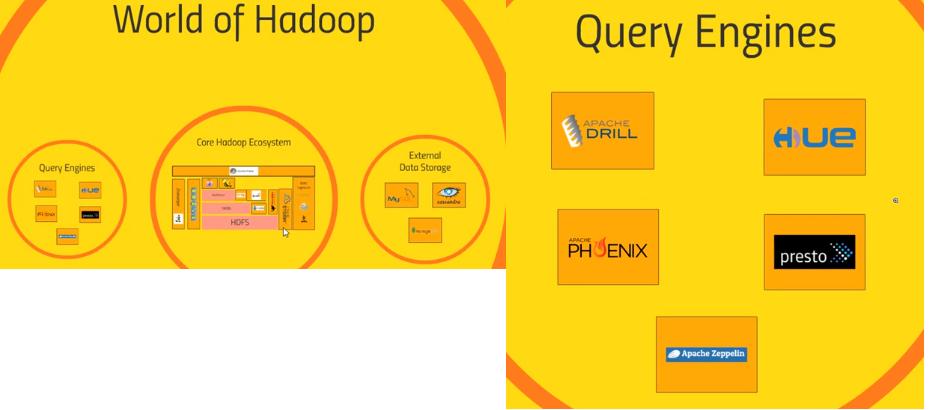

External query engines can sit on top of various storage technologies we might have.

* Apache drill: Lets us issue SQL queries across a wide range of stuff that might be in our cluster, (In you wider cluster, not just Hadoop).
  + It can issue queries across MongoDB or files that happen to be sitting on HDFS or S3 or Google Cloud or Azure, etc... It can also talk to Hive and HBase and unify these all into single SQL queries.

* Apache Phoenix: It sits on top of HBase.

* Presto: It's a lot like Drill in that it lets you execute SQL queries across a variety of different storage technologies, but instead of being made by apache, it is made by Facebook (Still open source).
  + NOTE: Presto can talk to cassandra while drill cannot. But Drill can talk to MongoDB and Presto cannot.
  + Which one you choose will probably be driven by which database technologies you actually have to integrate with

## Apache Drill

It's a system that sits on top of your various technologies for storing data, and it basically lets you execute actual SQL queries on top of data that might not have a schema at all.

**Basically it's a SQL engine that allows you to run relational looking SQL queries across a variety of dataframes.**

* A SQL engine for a variety of non-relational databases and data files
  - Hive, MongoDB, HBase
  - Even flat JSON or Parquet files on HDFS, S3, Azure, Google cloud, local file system.

* Based on Google's Dremel

**Drill it's actual SQL:**
  * Not SQL-like (ACTUAL SQL): It's pretty standard.
  * And it has a ODBC / JDBC driver so other tools can connect to it just like any relational database.

NOTE: Drill could actually kindof replace Hive, Hive allows you to query data with Hive QL (HQL) With Drill you can literally just use SQL.

Drill gets powerful because it  also exposes an interface to other tools that makes it look just like a relational databse. This is called ODBC or JDBC, and using that driver, you can connect external tools like Tableau or anything that expects to connect to a relational datbase and use it just like a relational databse.

**Apache is also fast and easy to set up**

Things to remember:
  * Under the hood the data is still non-relational.
  * Allows SQL analysis of disparate data source without having to transform and load it first.
    - Internally data is represented as JSON and has no fixed schema.
  * Basically don't push your system to do something it was not designed to do.
    - Sometimes it's better if you just use an actual Non-relational databse.

**Drill allows SQL analysis of disparate data sources, but without having to transform and load it first, so it really talks about having a SQL without a schema**


**Apache can even do joins across different database technologies**
  * Or with flat JSON files "sitting around"

**Think of this as SQL for (almost) your entire ecosystem and databases.**

Activity:
  * We will import data into Hive And MongoDB
  * Set up Drill on top of both
  * Do queries on top of both systems at the same time.


# 2. Setting up Drill

1. Start HDP virtualbox 
2. Log into Ambari.
3. Go to MongoDB in the sidebar -> service Action -> Start
4. Go to the grid icon -> Hive View -> Import ratings data in hive.
  1. `CREATE DATABASE movidelens;` -> execute
  2. Go to upload Table tab.
  3. -> upload your file (Remember to add the proper separator). Remember to select to import into the proper (movielens) database. The file we uploaded were the ratings.

Now we add the data into MongoDB

5. Log in into PuTTY (Remember that you configured it to run in your localserver and in HDP).
6. `su root`
7. NOTE: In previous videos we used the ML-100k file and the script MongoSpark.py (Which imports data from HDFS into MongoDB).
8. `export SPARK_MAJOR_VERSION = 2` -> `spark-submit --packages org.mongodb.spark:mongo-spark-connector_2.11:2.0.0 MongoSpark.py` -> run it and now we have the data.

**Now we install Drill**
NOTE: You have to install the Drill version that works with the Hive and HDP version you have in your sandbox, different versions do not work togheter and you have to check those compatibilities.
1. in PuTTY -> `wget http://archive.apache.org/dist/drill/drill-1.12.0/apache-drill-1.12.0.tar.gz`
2. `ls` (To see if the file is there) -> `tar -xvf apache-drill-1.12.0.tar.gz` To decompress the file. Once it is decompressed it is already installed. 

**Start Drill** 
1. From the same place as before we use `cd apache-drill-1.12.0` to go to the folder and then -> `bin/drillbit.sh start -Ddrill.exec.port = 8765` We are starting apache and also we have to overide the default port that drill runs on, (last part of code) this is because we have to use a port that's open all the way through the outside world so we can actually communicate with drill from our web browser that's running on our host system. The port we chose (8765) is a port already open but currently unused by HDP (Note: sometimes you have to set up this ports manually all the way from the sandbox).




### Now we connect to drill

We have to go to 127.0.0.1:8765 and we see the DrillUI. Note: We still have to actually connect it to our instances of MongoDB and Hive.

Whithin the apache server:

1. Go to the storage tab in the navbar
2. Hit the enable button next to Hive and Mongo (Note: you also need cp and dfs but they should be already enabled).
3. Click update in the hive button and change the localhost URL: The json should have a section of: `"hive.metastore.urls": ""` and you should change it to: `"hive.metastore.urls": "thrift://localhost:9083"` Basically you add the value between the empty quotes. This tells Drill that Hive can be found running on the localhost on that port (which is the default port) 
4. Click the update button.

  NOTE: You can update the configuration of where everything connects and the ports cicking the update buttons of any service you want to use.

# 3. Queryng acroos multiple databases with Drill.
In the query tab of Apache Drill.

* In the query we can type `SHOW DATABASES;` to see the databases we are working on. It returns a list with everything we have availiable (This includes some configuration files) But we can find our data: hive.movielens and mongo.movielens

* `SELECT * FROM hive.movielens.rating LIMIT 10;` Simple SQL Query that gives us the first 10 results of the ratings from movielens data from hive.

Same thing for mongoDB:

* `SELECT * FORM mongo.movielens.uers LIMIT 10;` 

Now we will join data from mongoDB and Hive.

Lets break down how many ratings were provided by each occupation. We need to join the users table to get the occupations and check which ID the user relates to. Both databases have user_id and we join by that.

* `SELECT u.ocupation, COUNT(*) FROM hive.movielens.ratings r JOIN mongo.movielens.users u ON r.user_id = u.user_id GROUP BY u.ocupation`
  + So the `GROUP BY u.ocupation` means that I want to group togheter all the users of a given occupation. 
  + You join that users table (with pseudonim u) with the ratings table from Hive (pseudo r) on the user_id column.
  + What you get back is a table of occupations and the number of ratings from the rating table (the first part of the code `SELECT u.occupations`) for each occupation (`COUNT(*)` the * means all)

Once we click submit we get the data.

**Now to clean/exit**

Shut down Drill
1. in PuTTY go to the apache-drill-1.9.0 directory
2. bin/drillbit.sh stop

Now we shut down MongoDB

1. In Ambari go to MongoDB (sideBar) -> ServiceActions -> Stop

# 4. Overview of Apache Phoenix.

Conceptually it is simlar to drill in that it offers a SQL interface on top of a non-relational database, The thing is that it only works with HBase and nothing else...

**What is phoenix** 
* A SQL driver for HBase that supports transactions. 
  + You could clump togheter SQL queries and commit them all at once, that way you can actually have a more complex transaction. 
    - This allows the transaction to be executed "Atomically" Which means that if someone queries the database it will not get the result of some intermediate step.
* Fast, low-latency - OTLP support (Online transaction, Processing, analytic queries)
* Originally developed by Salesforce then open-sourced
* Exposes a JDBC connector for HBase
* Supports secondary indices and user-defined functions.
* Integrates with MapReduce, Spark, Hive, Pig and Flume.

NOTE: even if it seems like this is a relational database, IT IS NOT, Be careful with your operations.



### Why use Phoenix.

* It's highly optimized. You probably won't pay a performance cost from having this extra layer on top of HBase.

* Why Peonix and not HBase native clients?
  - Your apps, and analysts, may find SQL easier to work with.
  - Phoenix can do the work of optimizing more complex queries for you
    + Still remember HBase is still fundamentally non-relational

Note: If you need speed and have some query you want to do, you could ask yourself: "Should I just create an HBase Table that just answers the question that I want more directly?" Because this way is the fastest. You have a simple table where the key is whatever you are quering on and the value is exactly what your application needs. DON'T USE PHOENIX AS A CRUTCH

### Phoenix architecture

It's mostly the HBase architecture but it has Pheonix on top or as a Co-Processor in some blocks.

We have an Phoenix client (we have an application) that talks to HBase region servers which talks to HDFS cluster to take the data. Also zookeeper keeps track of what region servers are availiable.


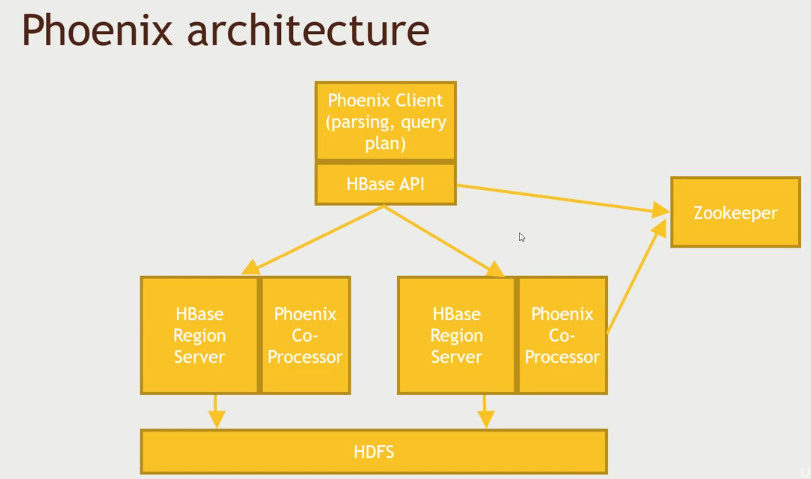

### Using phoenix
There are many ways to use phoenix:
* Command-Line Interface (CLI)
* Phoenix API for Java
* JDBC Driver (Thick client)
* Phoenix Query Server (PQS) thin client
  - Intended to eventually envable non JVM acess
* JAR's for MapReduce, Hive, Pig, Spark



Activity:
* Install Phoenix on our Hortonworks Sandbox
* Mess around with the CLI
* Set up a users table for MovieLens
* Store and load data to it through Pig.

We will store the MovieLens user data into HBase using Pig and then we will load it back and do some queries on it through pig.

# 5. Install Phoenix and query HBase with it.

First we need to make sure HBase is running

1. Get into Ambari -> Hbase (in sidebar) -> Service actions -> Start.

Intalling Phoenix
2. Log inro PuTTY (Remember to log in through SSH in HDP) 
  1. `yum install phoenix`

  Literally it is installed.

Now to run it

1. `cd /usr/hdp/current/phoenix-client/` <- where phoenix is installed, -> now we go to bin folder `cd bin`  ->  `python sqlline.py` and that should kick up phoenix and we are in the prompt now.

Now we play with it.

1. `!tables` This gets a list of the tables we have in HBase.
2. `CREATE TABLE IF NOT EXISTS us_population(
  state CHAR(2) NOT NULL,
  city VARCHAR NOT NULL
  population BIGINT
  CONSTRAINT my_pk PRIMARY KEY (state,city));` 
    - This code creates a table in HBase if there is no table with the same name
    - it has the columns state,city and population with their respective types.
    - we define the primary key as my_pk and it consists of state,city pairs (Because there should not be any repeated value of these pairs)
  
Our table is created.

Adding data:

NOTE: Phoenix does not know what INSERT means, it uses UPSERT. Which means that im going to insert this row but if it already exists im going to update the contents of the existing row.
1. `UPSERT INTO US_POPULATION ('NY','New York',192317);` here we insterted that data into our database.
2. To see what's in the table `SELECT * FROM US_POPULATION;` or for more complex queries: `SELECT * FROM US_POPULATION WHERE STATE = 'CA';`

Now we clean up

1. `DROP TABLE US_POPULATION`
2. `!quit` <- to get out of phoenix.


# 6. Integrate Phoenix with Pig

We will write a Pig script that uses Phoenix to actually write and store our users data table into HBase via phoenix and then do some queries on it through phoenix.

We need to create a table to work with (open phoenix with the commands of prev vid `python sqlline.py` 

To create the table

1. `CREATE TABLE users ( USERID INTEGER NOT NULL, AGE INTEGER, GENDER CHAR(1), OCCUPATION VARCHAR, ZIP  VARCHAR CONSTRAINT pk PRIMARY KEY(USERID)
);`

and our table is created.

Now we `!quit` and go back to our home directory `cd /home/maria_dev` and here we need to have the ml-100k directory that contains the u.user file (You might already have it, if not follow the steps)
1. `mkdir ml-100k` -> `cd ml-100k` -> `wget http://media.sundog.com/hadoop/ml-100k/u.user` (Basically get the data there)
2. cd back up to your home directory `cd /home/maria_dev`
3. Now download pig script: `wget http://media.sundog-soft.com/hadoop/phoenix.pig`
4. `pig phoenix.pig` to run it

To clean up
1. `cd /usr/hdp/current/phoenix-clients/bin` -> `python sqlline.py` (Now we are in phoenix CLI) -> `DROP TABLE users;` to drop the table -> `!quit` to quit out of phoenix
2. In ambari -> HBase -> Service Actions -> Stop.

In [0]:
# We need to REGISTER command to tell the program where to get the client libraries for phoenix.
# basically go to that folder and use the phoenix-client.jar file
REGISTER /usr/hdp/current/phoenix-client/phoenix-client.jar

# We LOAD the database u.user using | as the delimeter with the columns
# USERID, AGE, GENDER, OCUPATION, ZIP, with their respective value types
users = LOAD '/user/maria_dev/ml-100k/u.user' 
USING PigStorage('|') 
AS (USERID:int, AGE:int, GENDER:chararray, OCCUPATION:chararray, ZIP:chararray);

# We STORE the data into HBase://users location
# We use the PhoenixHBaseStorage connector
# The parameters are the hostname where phoenix is running 
# A batch size to commit entries at one. (No bigger than what you can fit in memory)
STORE users into 'hbase://users' using
    org.apache.phoenix.pig.PhoenixHBaseStorage('localhost','-batchSize 5000');

# Load the ocupations from HBase using phoenix
# We create a new occupations relation with only the USERID and Occupation
occupations = load 'hbase://table/users/USERID,OCCUPATION' using org.apache.phoenix.pig.PhoenixHBaseLoader('localhost');

# GROUP the data by occupation
grpd = GROUP occupations BY OCCUPATION; 
# Count the data
# We have occupation: {All user ID's}
# FOREACH in the database GENERATE a new group with everyone with the
# Occupation name and the count that many times that occupation occurred.
cnt = FOREACH grpd GENERATE group AS OCCUPATION,COUNT(occupations);
#Print the cnt database
DUMP cnt;  


This returns a database like: 

(doctor,7)

(executive, 32)

(programmer, 66)

NOTE: Usually in the real world you interact with Phoenix through the JDBC client (Java) to make any application.

# 7. Overview of Presto

* Presto is a lot like Drill
  - It can connect to many "big data" databases and data stores at once, and query across all of them.
  - Familiar SQL syntax.
  - Optimized for OLAP - analytical queries, data warehousing.
    + Not really ment for getting high transaction rates or being super quick in its latency, (It works seconds instead of micro-miliseconds)

* Developed and mantained (partially) by Facebook.
* Exposes JDBC, Command-line and Tableau interfaces. 

### Why presto

* It has a Cassandra conector.
* Facebook uses it
  - Facebook has over 300PB of data and it runs more than 30k queries per day, so it's probably good for you.
  - DropBox and AirBNB uses it.

* A single Presto query can combine data from multiple sources, allowing for analytics across your entire organization.

* "Presto breaks the false choice between having fast analytics using an expensive commercial solution or using a slow "free" solution that requires extensive hardware" - Basically you get the best of both worlds.

### What can Presto connect to
* Cassandra (Also mantained by FB)
* Hive
* MongoDB
* MySQL
* LocalFiles
* Stuff like
  - Kafka (streaming data application)
  - JMX
  - PostgreSQL
  - Redis
  - Accumelo




# 8. Install presto and query Hive with it.

Have you HDP machine open
1. In PuTTY `su root`
2. `wget https://repo1.maven.org/maven2/com/facebook/presto/presto-server/0.234/presto-server-0.234.tar.gz` You can get that link by going to the presto website https://prestodb.io/docs/current/installation/deployment.html and copy the link direction  NOTE: in a professional setting you should install in some relevant location, not just your user.
3. `tar -xdf presto-server-0.234.tar.gz ` To decompress

NOTE: We don't have any configuration at all. So there are a lot of configuration files that are supposed to live under the /etc/ directory which does not even exist... We need to create and populate the files. All the documentation for that is on the same site where you found the download link. Thing is, these configurations all change depending on where everything is (your severs, your database, your ports), and doing it by hand "forces" you to know what you are doing.

This course comes with "default" options for what we are doing.

4. `wget http://media.sundog-soft.com/hadoop/presto-hdp-config.tgz`
5. `tar -xvf presto-hdp-config.tgz` that created the /etc/ directory with its files
  * We have config.properties
    + It indicates ports, max-memory, recovery server, etc...
  * JPM.config
    + Java parameters and properties
  * node.properties:
    + gives node.id is a unique identifier for every machine you are using.
  * catalog (which has Hive.properties)
    - This has ports 

NOTE: REALLY DO THIS MANUALLY IN A "REAL" environment.

Now we need to download the CLI
1. make sure you are into the bin folder in presto-server and run `wget https://repo1.maven.org/maven2/com/facebook/presto/presto-cli/0.234/presto-cli-0.234-executable.jar` You also get that from the site but in https://prestodb.io/docs/current/installation/cli.html 
2. We need to rename the file `mv presto-cli-0.234-executable.jar presto` This moves it to a new name, basically we just renamed it to a file named "presto".
3. Now we need to make the file executable `chmod +x presto` that means it is an executable command that we can now run and that will kick off the command line interface when we launch it with the appropiate parameters.
4. Now we launch presto -> go to the top of the presto server directory -> `cd /home/maria_dev/presto-server-xxx` and now we have to type `bin/launcher start` 

Now we can connect to the web interface to presto: 
127.0.0.1:8090

Now connecting through the CLI (in PuTTY)
  1. `bin/presto --server 127.0.0.1:8090 --catalog hive`
NOTE: you should have the ratings table in Hive. (Else just import it, pretty easy -> hive view -> import)

2. We are now in the presto prompt: `show tables from default;` and we get our list of tables (the ratings table should be here)

3. `select * from default.ratings limit 10;` <- simple SQL query. or `select * from default.ratings where rating = 5 limit 10;` or we can `select count(*) from defaut where rating=1;` These are just random queries. 

4. To quit/stop from presto `bin/launcher stop`


# Query both Cassandra and hive using presto

1. in PuTTY (presto-server) same from last lecture. `scl enable python27 bash` we have to use this version of python for presto (or was it cassandra?).
2. `service cassandra start`
3. `nodetool enablethrift` to let Presto comunicate with cassandra.
4. `cqlsh --cqlversion="3.4.0"` To enter cassandra slh
5. `describe keyspaces` To see our tables/databases.
6. `use movielens;` -> `describe tables;` -> `select * from users limit 10;` We do have the data. -> `quit` to exit cassandra.

We will use this data combined with the ratings data in hive using Presto.

We now need to set up a configuration file for it with Presto -> `etc/catalog` -> `vi cassandra.properties` -> `i` This is because this text editor needs you to press 'i' to insert text -> `connector.name = cassandra` -> `cassandra.contact-points = 127.0.0.1` -> press 'esc' -> `:wq` to write and quit the file. -> We just created a new file called cassandra.properties. Now we go back to presto-server directory (cd twice)

Now to start presto -> `bin/launcher start` -> now to connect to the Presto CLI -> `bin/presto --server 127.0.0.1:8090 --catalog hive,cassandra` The catalog part tells the program that we will connect to hive and cassandra at the same time.

1. `show tables from cassandra.movielens;` and we see our users table in cassandra. -> `describe cassandra.movielens.users;`
2. `select * from hive.default.ratings limit 10;` and we now have the hive ratings.
3. select `u.occupation, count(*) from hive.default.raings r join cassandra.movielens.users u on r.user_id = u.user_id group by u.occupation;` this is a SQL query where we select all the occupation from hive ratings (define it as r) and join it to the users on cassandra (defined as u) on r.user_id = u.user_id meaning that we will join by that column and then we group by u.ocupation.
  - This returns the count of ratings per occupation, literally two columns (occupation, count of ocuation)

To clean up
1. `quit` -> `bin/launcher stop` to stop presto -> `service cassandra stop`
